In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import torch

train_on_gpu = torch.cuda.is_available() # if cuda is available than training on GPU else on CPU 

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip # unzip data

In [ ]:
import pickle # For work with images
import random
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# in sklearn we have some problems with inserting images to colab
# we will ignore warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
SEED = 1937

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [ ]:
# List with modes of datasets 
DATA_MODES = ['train', 'val', 'test']
# settting rescaling size of image to 224x224
RESCALE_SIZE = 224
# setting GPU device
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Dataset that will take images from dirs and augmentate them
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # to convert images to PyTorch tensors and normalize the input
        if self.mode == 'train': 
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))


In [ ]:
def create_dct_from_labels(train_val_labels):
    """The function creates a dict dictionary from the list train_val_labels, which contains class labels
       corresponding to images from the selection, with keys corresponding
       to class names, and values corresponding to the number of these classes in
       the list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files] # классы train + val
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [ ]:
def create_dct_path_labels(train_files, train_labels):
    """The function creates a dictionary in which the key is the name of the character, and 
       the value is the path where you can find images with this character
    """
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

# Creating dictionary with pathes to images
dct_path_train = create_dct_path_labels(train_files, train_labels)

# Checking result
print_dct(dct_path_train)


# If images of some class < 100 than fill this class with copies
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

# Checking number of images for all classes
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

# выведим на печать класс:количесвто картинок для train должно быть примерно 75 %
print_dct(create_dct_from_labels(new_train_label))

abraham_grampa_simpson	[PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0123.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0342.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0549.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0551.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0698.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0263.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0741.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0592.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0429.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0130.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0220.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0548.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0052.jpg'), PosixPath('train/simpsons_d

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val') # Creating validation dataset
new_train_dataset = SimpsonsDataset(new_train_files, mode='train') # Creating train dataset

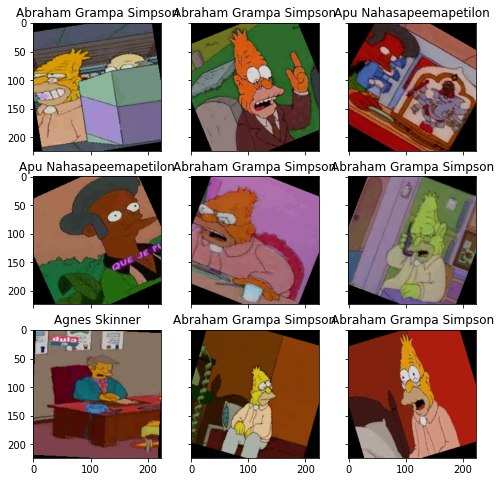

In [ ]:
# Showing random 9 images
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = new_train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### **Как мы видим, данные для обучения сети будут поставляться с аугментациями**

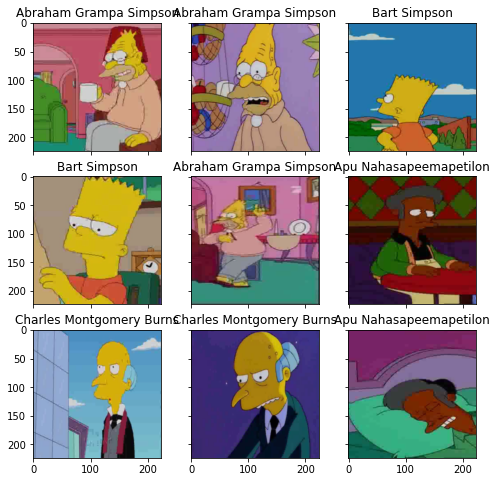

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """This function will represent 1 epoch of fitting"""
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE) # For calculating on GPU
        labels = labels.to(DEVICE) # For calculating on GPU
        optimizer.zero_grad() # reset to zero old gradients of optimizer

        outputs = model(inputs) # calculating model outputs 
        loss = criterion(outputs, labels) # Finding loss of our model
        loss.backward() # Making gradient descent by our graph of calculating
        optimizer.step() # making step of our optimizer
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    """This function will represent 1 evaluation epoch"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False): # We do not need to calculate gradients and just set gradients calculating to False
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_dataset, val_dataset, model, epochs, batch_size, shuffle=True, sampler=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=4) # Making loader for train with shuffling
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Making loader for validation without shuffling

    history = [] # List with history of accuary
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters()) # casual optimizer
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 3, 0.5) # Casual scheduler
        criterion = nn.CrossEntropyLoss() 

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    """Function will predict probabilities of accessories image to all classes"""
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))

In [ ]:
from torchvision import models

In [ ]:
model = models.resnet50(pretrained=True).to(DEVICE) # using pretrained neural network resnet50

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
model.fc = nn.Sequential(nn.Linear(2048,n_classes)) # changing last layer on layer that will aproach to our task 

In [ ]:
model = model.cuda()

Запустим обучение сети.

In [ ]:
import copy

# saving weights of our model
model_pre_weights = copy.deepcopy(model.state_dict())
torch.save(model_pre_weights, "path_to\\model_pre_weights.pth")

In [ ]:
history = train(new_train_dataset, val_dataset, model=model, epochs=30, batch_size=64) # training

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 1.16525652164466


epoch:   3%|▎         | 1/30 [08:01<3:52:34, 481.19s/it]


Epoch 001 train_loss: 1.1653     val_loss 0.8436 train_acc 0.7052 val_acc 0.7820
loss 3.3531086885142374


epoch:   7%|▋         | 2/30 [15:46<3:42:17, 476.36s/it]


Epoch 002 train_loss: 3.3531     val_loss 3.1654 train_acc 0.0948 val_acc 0.1074
loss 3.2850563455594646


epoch:  10%|█         | 3/30 [23:28<3:32:29, 472.19s/it]


Epoch 003 train_loss: 3.2851     val_loss 3.0951 train_acc 0.0993 val_acc 0.1087
loss 3.202384404848228


epoch:  13%|█▎        | 4/30 [31:11<3:23:27, 469.50s/it]


Epoch 004 train_loss: 3.2024     val_loss 2.9933 train_acc 0.1063 val_acc 0.1278
loss 3.077637659116905


epoch:  17%|█▋        | 5/30 [38:57<3:15:04, 468.18s/it]


Epoch 005 train_loss: 3.0776     val_loss 2.7301 train_acc 0.1410 val_acc 0.2209
loss 2.7133390035880462


epoch:  20%|██        | 6/30 [46:44<3:07:12, 468.04s/it]


Epoch 006 train_loss: 2.7133     val_loss 2.1684 train_acc 0.2546 val_acc 0.4182
loss 2.171473335747043


epoch:  23%|██▎       | 7/30 [54:32<2:59:23, 467.99s/it]


Epoch 007 train_loss: 2.1715     val_loss 1.7993 train_acc 0.4038 val_acc 0.5076
loss 1.8197146556828283


epoch:  27%|██▋       | 8/30 [1:02:20<2:51:35, 467.97s/it]


Epoch 008 train_loss: 1.8197     val_loss 1.4197 train_acc 0.5013 val_acc 0.6152
loss 1.4465129914880681


epoch:  30%|███       | 9/30 [1:10:08<2:43:50, 468.10s/it]


Epoch 009 train_loss: 1.4465     val_loss 1.2215 train_acc 0.6040 val_acc 0.6720
loss 1.076390657498308


epoch:  33%|███▎      | 10/30 [1:17:57<2:36:06, 468.33s/it]


Epoch 010 train_loss: 1.0764     val_loss 0.9311 train_acc 0.7074 val_acc 0.7430
loss 0.9200934149274179


epoch:  37%|███▋      | 11/30 [1:25:46<2:28:20, 468.46s/it]


Epoch 011 train_loss: 0.9201     val_loss 0.8192 train_acc 0.7484 val_acc 0.7797
loss 0.8126977392963207


epoch:  40%|████      | 12/30 [1:33:36<2:20:39, 468.85s/it]


Epoch 012 train_loss: 0.8127     val_loss 0.7420 train_acc 0.7761 val_acc 0.8011
loss 0.6770451690325832


epoch:  43%|████▎     | 13/30 [1:41:26<2:12:55, 469.12s/it]


Epoch 013 train_loss: 0.6770     val_loss 0.6261 train_acc 0.8104 val_acc 0.8294
loss 0.6192852087753276


epoch:  47%|████▋     | 14/30 [1:49:16<2:05:10, 469.39s/it]


Epoch 014 train_loss: 0.6193     val_loss 0.5967 train_acc 0.8258 val_acc 0.8370
loss 0.5796192015970766


epoch:  50%|█████     | 15/30 [1:57:06<1:57:24, 469.64s/it]


Epoch 015 train_loss: 0.5796     val_loss 0.5932 train_acc 0.8350 val_acc 0.8470
loss 0.496620000574708


epoch:  53%|█████▎    | 16/30 [2:04:56<1:49:38, 469.89s/it]


Epoch 016 train_loss: 0.4966     val_loss 0.5421 train_acc 0.8617 val_acc 0.8598
loss 0.4775632211180543


epoch:  57%|█████▋    | 17/30 [2:12:47<1:41:51, 470.10s/it]


Epoch 017 train_loss: 0.4776     val_loss 0.5466 train_acc 0.8649 val_acc 0.8544
loss 0.46156472977748036


epoch:  60%|██████    | 18/30 [2:20:37<1:34:02, 470.22s/it]


Epoch 018 train_loss: 0.4616     val_loss 0.5186 train_acc 0.8684 val_acc 0.8672
loss 0.42336489267517174


epoch:  63%|██████▎   | 19/30 [2:28:28<1:26:11, 470.18s/it]


Epoch 019 train_loss: 0.4234     val_loss 0.5083 train_acc 0.8805 val_acc 0.8634
loss 0.41640902016952425


epoch:  67%|██████▋   | 20/30 [2:36:18<1:18:22, 470.27s/it]


Epoch 020 train_loss: 0.4164     val_loss 0.5096 train_acc 0.8830 val_acc 0.8659
loss 0.3944233820261282


epoch:  70%|███████   | 21/30 [2:44:09<1:10:33, 470.34s/it]


Epoch 021 train_loss: 0.3944     val_loss 0.4954 train_acc 0.8887 val_acc 0.8731
loss 0.3777672597151178


epoch:  73%|███████▎  | 22/30 [2:51:59<1:02:42, 470.37s/it]


Epoch 022 train_loss: 0.3778     val_loss 0.4891 train_acc 0.8946 val_acc 0.8710
loss 0.37539446083318906


epoch:  77%|███████▋  | 23/30 [2:59:49<54:52, 470.37s/it]


Epoch 023 train_loss: 0.3754     val_loss 0.4903 train_acc 0.8946 val_acc 0.8728
loss 0.364804327135151


epoch:  80%|████████  | 24/30 [3:07:40<47:02, 470.34s/it]


Epoch 024 train_loss: 0.3648     val_loss 0.4910 train_acc 0.8948 val_acc 0.8720
loss 0.3569380662786287


epoch:  83%|████████▎ | 25/30 [3:15:30<39:12, 470.42s/it]


Epoch 025 train_loss: 0.3569     val_loss 0.4913 train_acc 0.8975 val_acc 0.8714
loss 0.3567128065564499


epoch:  87%|████████▋ | 26/30 [3:23:20<31:21, 470.35s/it]


Epoch 026 train_loss: 0.3567     val_loss 0.4848 train_acc 0.8983 val_acc 0.8728
loss 0.34915646844430237


epoch:  90%|█████████ | 27/30 [3:31:10<23:30, 470.26s/it]


Epoch 027 train_loss: 0.3492     val_loss 0.4900 train_acc 0.9008 val_acc 0.8745
loss 0.34805523691956336


epoch:  93%|█████████▎| 28/30 [3:39:00<15:40, 470.12s/it]


Epoch 028 train_loss: 0.3481     val_loss 0.4846 train_acc 0.9019 val_acc 0.8743
loss 0.35124383416356475


epoch:  97%|█████████▋| 29/30 [3:46:50<07:50, 470.17s/it]


Epoch 029 train_loss: 0.3512     val_loss 0.4835 train_acc 0.9014 val_acc 0.8766
loss 0.3476713542976687


epoch: 100%|██████████| 30/30 [3:54:40<00:00, 469.36s/it]


Epoch 030 train_loss: 0.3477     val_loss 0.4811 train_acc 0.9017 val_acc 0.8766


In [ ]:
# saving weights after training
model_30epoch_weights = copy.deepcopy(model.state_dict())
torch.save(model_30epoch_weights, "gdrive/My Drive/model_resnet50_30epoch_weights.pth")

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

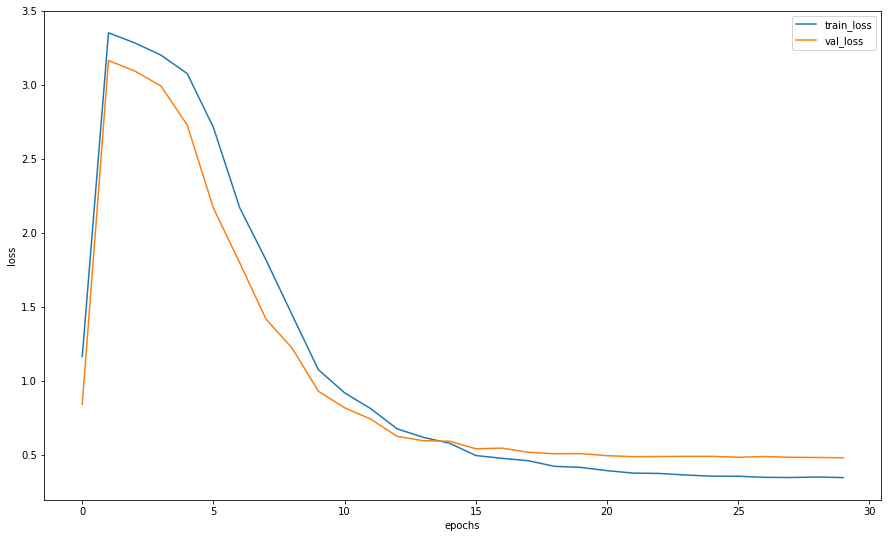

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Predictions for 1 image"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Так как целевая метрика является f1-score, проверим, какой скор она выдаст


In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.9500000000000001

Сделаем классную визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах.


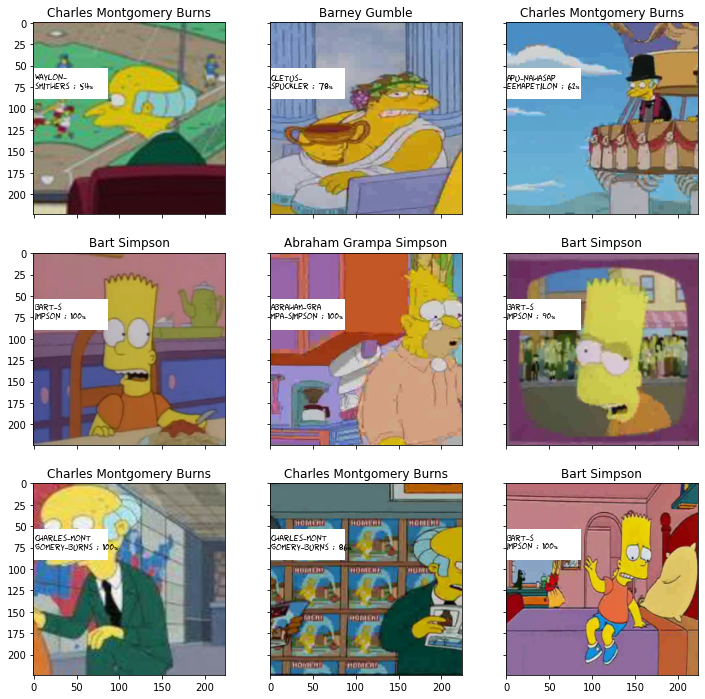

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# **Submit на Kaggle**

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
! ls 

 characters_illustration.png  'path_to\model_pre_weights.pth'   testset
 gdrive			       sample_data		        train
 label_encoder.pkl	       sample_submission.csv


In [ ]:
import pandas as pd
mysubmit = pd.DataFrame(columns=['Id'])
test_filenames = [path.name for path in test_dataset.files]
mysubmit['Id'] = test_filenames

In [ ]:
mysubmit[f'Expected'] = preds

In [ ]:
mysubmit.to_csv('gdrive/My Drive/3.csv', index=False)